In [136]:
import pandas as pd
import requests
from typing import List
import numpy as np
import pandas_ta
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [137]:
def get_sp500_tickers() -> List[str]:
    """
    Scrapes the current list of S&P 500 constituent stock tickers from Wikipedia.
    
    Uses requests with a User-Agent to prevent HTTP 403 Forbidden errors, 
    then uses pandas.read_html() to parse the HTML table.

    Returns:
        A list of strings containing the S&P 500 company tickers.
        Returns an empty list [] if fetching or parsing fails.
    """
    WIKI_URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # Define a standard User-Agent header to avoid 403 Forbidden errors
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        print(f"Attempting to fetch HTML content from: {WIKI_URL}")
        
        # 1. Fetch the HTML content using requests with a User-Agent
        response = requests.get(WIKI_URL, headers=HEADERS, timeout=10)
        response.raise_for_status() # Raise an exception for HTTP errors (like 403)
        tables = pd.read_html(response.text)
        sp500_table = tables[1]
        
        if 'Symbol' in sp500_table.columns:
            # 4. Extract and clean the tickers
            tickers = sp500_table['Symbol'].tolist()
            
            # Clean up potential odd entries (like leading/trailing whitespace or footnotes)
            tickers = [ticker.strip().replace('.', '-') for ticker in tickers if isinstance(ticker, str)]
            
            print(f"Successfully retrieved {len(tickers)} tickers.")
            return tickers
        else:
            print("Error: Could not find the 'Symbol' column in the expected table structure.")
            return []
            
    except requests.exceptions.HTTPError as e:
        # Catch 4XX errors specifically
        print(f"Error: HTTP Status {e.response.status_code}. The server rejected the request. Try running again.")
        return []
    except Exception as e:
        print(f"An error occurred while scraping the Wikipedia page: {e}")
        print("This may be due to a network error, a change in the Wikipedia page structure, or missing dependencies.")
        return []


sp500_list = get_sp500_tickers()
    

Attempting to fetch HTML content from: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies


C:\Users\kudam\AppData\Local\Temp\ipykernel_37048\2972335050.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Successfully retrieved 503 tickers.


In [138]:
sp500_list[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [139]:
import yfinance as yf
# Download historical data for all tickers from 2016-01-01
data = yf.download(tickers=sp500_list, start='2015-01-04', end='2025-08-31', auto_adjust=False, group_by='ticker', threads=True)

if not data.empty:
    print('Data fetched successfully for S&P 500 tickers!')
    df = data
else:
    print('Failed to fetch data for S&P 500 tickers.')
    df = None

df.columns = df.columns.swaplevel(0, 1)
df = df.sort_index(axis=1, level=0)
df = df.stack()

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['SOLS', 'Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-04 -> 2025-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1420347600, endDate = 1756612800")')


Data fetched successfully for S&P 500 tickers!


C:\Users\kudam\AppData\Local\Temp\ipykernel_37048\2145885422.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [140]:
df

Price               Adj Close       Close  ...        Open       Volume
Date       Ticker                          ...                         
2015-01-05 A        36.425385   39.799999  ...   40.320000    2041800.0
           AAPL     23.554743   26.562500  ...   27.072500  257142000.0
           ABBV     41.299290   64.650002  ...   65.500000    8007400.0
           ABT      36.426788   44.910000  ...   44.799999    5735900.0
           ACGL     18.428413   19.379999  ...   19.393333    1095900.0
...                       ...         ...  ...         ...          ...
2025-08-29 XYZ      79.639999   79.639999  ...   80.800003    6205700.0
           YUM     146.260010  146.970001  ...  145.410004    1473400.0
           ZBH     105.840904  106.099998  ...  105.190002     680100.0
           ZBRA    317.089996  317.089996  ...  321.660004     440900.0
           ZTS     155.857315  156.399994  ...  154.639999    1534600.0

[1301889 rows x 6 columns]

In [141]:
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['High'] - np.log(df['Low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['Adj Close']) - np.log(df['Open']) ** 2))
df['rsi'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: pandas_ta.rsi(x, length=20))
df['bb_low'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,1])
df['bb_high'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,2])

c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Date'>

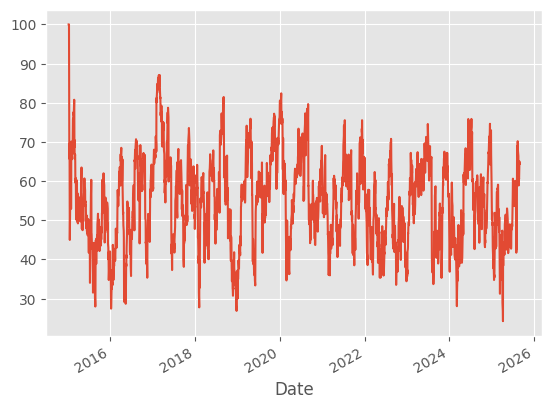

In [142]:
# All 'Close' prices for ticker 'AAPL' across all dates
df.xs('AAPL', level='Ticker')['rsi'].plot()

In [143]:
df.xs('A', level='Ticker')

Price,Adj Close,Close,High,Low,Open,Volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high
Date,,,,,,,,,,,
2015-01-05,36.425385,39.799999,40.459999,39.700001,40.320000,2041800.0,5.536737,NaN,NaN,NaN,NaN
2015-01-06,35.857956,39.180000,40.020000,39.020000,39.810001,2080600.0,5.500655,0.000000,NaN,NaN,NaN
2015-01-07,36.333858,39.700001,39.810001,39.290001,39.520000,3359700.0,5.469849,4.227597,NaN,NaN,NaN
2015-01-08,37.422981,40.889999,40.980000,40.180000,40.240002,2116300.0,5.528581,13.079766,NaN,NaN,NaN
2015-01-09,37.148411,40.590000,41.000000,40.290001,41.000000,1644900.0,5.584968,12.766626,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,118.911224,119.150002,121.690002,118.480003,121.500000,1482500.0,9.351057,52.574595,4.724850,4.769673,4.814495
2025-08-26,118.062927,118.300003,119.629997,118.110001,119.230003,1898200.0,9.273650,51.277935,4.725227,4.769031,4.812835
2025-08-27,118.452141,118.690002,119.199997,117.510002,118.500000,1698600.0,9.247735,51.851456,4.725211,4.769299,4.813388


In [144]:
def compute_atr(stock_data: pd.DataFrame, period: int = 14) -> pd.Series:
    atr = pandas_ta.atr(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Adj Close'], length=period)
    return atr.sub(atr.mean()).div(atr.std())

In [145]:
df['atr'] = df.groupby(level='Ticker', group_keys=False).apply(compute_atr)

In [146]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [147]:
df['macd'] = df.groupby(level='Ticker', group_keys=False)['Adj Close'].apply(compute_macd)

In [148]:
df['dollar_volume'] = (df['Volume'] * df['Adj Close'])/1e6

In [149]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'Volume', 'Open', 'High', 'Low', 'Close']]
data = pd.concat([df.unstack(level='Ticker')['dollar_volume'].resample('ME').mean().stack(level='Ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack(level='Ticker', future_stack=True)], axis=1).dropna()

In [150]:
data

dollar_volume   Adj Close  ...       atr      macd
Date       Ticker                             ...                    
2015-02-28 A          102.448352   38.631050  ... -0.562305  0.302436
           AAPL      6698.771482   28.590908  ... -0.169444  0.287035
           ABBV       512.523637   38.938370  ...  0.581620 -0.491418
           ABT        223.293609   38.625488  ...  0.529014  0.339132
           ACGL        24.453041   18.751719  ... -1.083175 -0.214140
...                          ...         ...  ...       ...       ...
2025-08-31 GEHC       222.226762   73.696602  ... -1.148203 -0.055023
           KVUE       356.788506   20.452362  ... -1.609633 -0.451282
           VLTO       103.525840  106.078842  ... -1.509690  0.190240
           SOLV        96.765372   73.089996  ... -0.958704 -0.181690
           GEV       1525.976451  612.714539  ...  1.359031 -0.405209

[61688 rows x 9 columns]

In [151]:
data

dollar_volume   Adj Close  ...       atr      macd
Date       Ticker                             ...                    
2015-02-28 A          102.448352   38.631050  ... -0.562305  0.302436
           AAPL      6698.771482   28.590908  ... -0.169444  0.287035
           ABBV       512.523637   38.938370  ...  0.581620 -0.491418
           ABT        223.293609   38.625488  ...  0.529014  0.339132
           ACGL        24.453041   18.751719  ... -1.083175 -0.214140
...                          ...         ...  ...       ...       ...
2025-08-31 GEHC       222.226762   73.696602  ... -1.148203 -0.055023
           KVUE       356.788506   20.452362  ... -1.609633 -0.451282
           VLTO       103.525840  106.078842  ... -1.509690  0.190240
           SOLV        96.765372   73.089996  ... -0.958704 -0.181690
           GEV       1525.976451  612.714539  ...  1.359031 -0.405209

[61688 rows x 9 columns]

In [152]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('Ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = data.groupby(level='Date')['dollar_volume'].rank(ascending=False)

In [153]:
data = data[data['dollar_vol_rank'] <= 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

**Calculate Monthly Returns for different time horizons as features**

In [154]:
data

Adj Close  garman_klass_volatility  ...       atr      macd
Date       Ticker                                       ...                    
2020-01-31 AAPL     74.678391                 7.823248  ... -0.358683  0.666814
           ABBV     64.025963                 7.943035  ...  0.086991 -0.769497
           ABT      78.711830                 8.220778  ...  0.732362  0.465800
           ACN     188.716354                11.591095  ...  0.554851  0.051530
           ADBE    351.140015                13.953320  ... -0.527314  0.823516
...                       ...                      ...  ...       ...       ...
2025-08-31 TTD      54.660000                 6.492244  ...  0.509221 -2.495952
           MRNA     24.090000                 4.028872  ... -0.886105 -0.160721
           UBER     93.750000                 8.457238  ...  1.457844  0.769849
           CRWD    423.700012                15.036715  ...  1.278427 -1.368597
           DDOG    136.679993                 9.919372  ...  0.010147 -0.345505

[10200 rows x 8 columns]

In [155]:
def calculate_monthly_returns(df: pd.DataFrame, outlier_cutoffs: float = 0.005) -> pd.DataFrame:
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['Adj Close'].pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoffs), upper=x.quantile(1 - outlier_cutoffs)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1)
                                   )
    return df

data = data.groupby(level='Ticker', group_keys=False).apply(calculate_monthly_returns).dropna()


In [156]:
data = data.rename_axis(index={'Date': 'date', 'Ticker': 'ticker'})
data = data.rename(columns={'Adj Close': 'adj_close'})


In [157]:
data

adj_close  garman_klass_volatility  ...  return_9m  return_12m
date       ticker                                       ...                       
2021-01-31 AAPL    128.456818                 9.806295  ...   0.068004    0.046237
           ABBV     85.314980                 8.825035  ...   0.029058    0.024210
           ABT     113.371727                 9.345782  ...   0.034519    0.030874
           ACN     225.946198                12.347622  ...   0.031394    0.015117
           ADBE    458.769989                15.205455  ...   0.029341    0.022530
...                       ...                      ...  ...        ...         ...
2025-08-31 DELL    121.716316                 9.434160  ...  -0.003219    0.006156
           TTD      54.660000                 6.492244  ...  -0.084706   -0.052595
           MRNA     24.090000                 4.028872  ...  -0.062495   -0.092685
           UBER     93.750000                 8.457238  ...   0.029706    0.020917
           CRWD    423.700012                15.036715  ...   0.022775    0.035965

[8035 rows x 14 columns]

Download Fama-French Factors and Calculate Rolling Betas

In [158]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                            'famafrench',
                            start='2016')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('ME').last().div(100)
factor_data.index.name =  'date'

C:\Users\kudam\AppData\Local\Temp\ipykernel_37048\731689923.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
C:\Users\kudam\AppData\Local\Temp\ipykernel_37048\731689923.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',


In [159]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-01-31 AAPL   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.005501
           ABBV   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.032397
           ABT    -0.0007  0.0681  0.0322 -0.0365  0.0497   0.133326
           ACN    -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.070684
           ADBE   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.082680
...                   ...     ...     ...     ...     ...        ...
2025-08-31 WFC     0.0185  0.0488  0.0442 -0.0068  0.0207   0.025211
           WMT     0.0185  0.0488  0.0442 -0.0068  0.0207  -0.007894
           XOM     0.0185  0.0488  0.0442 -0.0068  0.0207   0.033263
           XYZ     0.0185  0.0488  0.0442 -0.0068  0.0207   0.030805
           ZTS     0.0185  0.0488  0.0442 -0.0068  0.0207   0.072776

[8035 rows x 6 columns]

In [180]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 12]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-01-31 AAPL   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.005501
           ABBV   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.032397
           ABT    -0.0007  0.0681  0.0322 -0.0365  0.0497   0.133326
           ACN    -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.070684
           ADBE   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.082680
...                   ...     ...     ...     ...     ...        ...
2025-08-31 WDAY    0.0185  0.0488  0.0442 -0.0068  0.0207   0.006278
           WFC     0.0185  0.0488  0.0442 -0.0068  0.0207   0.025211
           WMT     0.0185  0.0488  0.0442 -0.0068  0.0207  -0.007894
           XOM     0.0185  0.0488  0.0442 -0.0068  0.0207   0.033263
           XYZ     0.0185  0.0488  0.0442 -0.0068  0.0207   0.030805

[7968 rows x 6 columns]

In [ ]:
def calculate_betas(df: pd.DataFrame, method: str) -> pd.DataFrame:
    """
    Calculate betas per ticker using either rolling OLS or recursive least squares (RLS).
    Returns a DataFrame with a MultiIndex (ticker, date) and factor columns (no 'const').
    """
    # factor columns inferred from dataframe (exclude target)
    factor_cols = [c for c in df.columns if c != 'return_1m']

    if method == 'rolling_ols':
        betas = (df.groupby(level='ticker', group_keys=False)
                    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                window=min(24, x.shape[0]),
                                                min_nobs=len(x.columns)+1)
                        .fit(params_only=True)
                        .params
                        .drop('const', axis=1)))
    elif method == 'rls':

        def rls_tv_beta(ts, factor_cols, y_col="return_1m", delta=0.2, init_P=1e6):
            # delta: forgetting factor close to 1 (e.g., 0.98-0.999); smaller = faster adaptation
            X_cols = ["const"] + factor_cols
            betas = []
            # initialize
            k = len(X_cols)
            theta = np.zeros(k)           # initial beta vector
            P = np.eye(k) * init_P
            for idx, row in ts.iterrows():
                x = np.concatenate(([1.0], row[factor_cols].values)).astype(float)  # shape (k,)
                y = float(row[y_col])
                # RLS update with forgetting factor (simplified Kalman)
                # Predict covariance
                P = P / delta
                # Gain
                Px = P.dot(x)
                gamma = 1.0 + x.dot(Px)
                K = Px / gamma
                # Update theta
                theta = theta + K * (y - x.dot(theta))
                # Update covariance
                P = P - np.outer(K, x).dot(P)
                betas.append({"date": idx, **{name: theta[i] for i,name in enumerate(X_cols)}})
            # return DataFrame indexed by date with columns ['const', *factor_cols]
            return pd.DataFrame(betas).set_index("date")

        # apply RLS per ticker, drop const to match rolling_ols output
        betas = (df.groupby(level='ticker', group_keys=False)
                    .apply(lambda x: rls_tv_beta(x.sort_index(), factor_cols=factor_cols, y_col='return_1m', delta=0.995))
                    .drop('const', axis=1))
    elif method == 'ridge':
        from sklearn.linear_model import Ridge

        def rolling_ridge_betas(ts, factor_cols, y_col='return_1m', window=24, alpha=1.0):
            res = []
            for i in range(window-1, len(ts)):
                win = ts.iloc[i-window+1: i+1]
                X = win[factor_cols].values
                y = win[y_col].values
                model = Ridge(alpha=alpha, fit_intercept=True).fit(X, y)
                params = dict(zip(['intercept'] + factor_cols, [model.intercept_] + list(model.coef_)))
                params['date'] = win.index[-1]
                res.append(params)
            return pd.DataFrame(res).set_index('date')

        betas = df.groupby(level='ticker', group_keys=False).apply(lambda x: rolling_ridge_betas(x.sort_index(), factor_cols=factor_cols, y_col='return_1m', window=24, alpha=1.0))
    else:
        raise ValueError("Unsupported method. Choose 'rolling_ols' or 'rls'.")

    return betas

betas = calculate_betas(factor_data, method='ridge')


In [187]:
betas = calculate_betas(factor_data, method='ridge')

C:\Users\kudam\AppData\Local\Temp\ipykernel_37048\772961357.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  .apply(lambda x: rolling_ridge_betas(ensure_sorted(x), factor_cols=factor_cols, y_col='return_1m',


TypeError: <class 'tuple'> is not convertible to datetime, at position 0

In [185]:
betas

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
AAPL   2021-01-31  0.000004 -0.000371 -0.000175  0.000199 -0.000271
       2021-02-28 -0.228635  0.180241 -0.317505 -0.314308  0.550301
       2021-03-31 -0.195103 -0.304784 -0.300583  0.234426  1.048491
       2021-04-30 -0.002592 -0.802494 -1.185213  0.108615  0.715442
       2021-05-31  1.354577 -0.019522 -1.500410  0.444608  1.028915
...                     ...       ...       ...       ...       ...
XYZ    2025-04-30  2.576315  0.631569 -0.301633 -2.760876  0.432785
       2025-05-31  2.529530  0.583002 -0.136370 -2.763657  0.205938
       2025-06-30  2.485428  0.582882 -0.006874 -2.574409 -0.010646
       2025-07-31  2.493546  0.577231  0.011085 -2.585239 -0.074288
       2025-08-31  2.496957  0.505412  0.011622 -2.583915 -0.103340

[7968 rows x 5 columns]

In [163]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(betas.groupby(level='ticker').shift())
data.loc[:, factors] = data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))


In [164]:
data = data.dropna()
data = data.drop('adj_close', axis=1)

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7989 entries, (Timestamp('2021-01-31 00:00:00'), 'AAPL') to (Timestamp('2025-08-31 00:00:00'), 'TTD')
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman_klass_volatility  7989 non-null   float64
 1   rsi                      7989 non-null   float64
 2   bb_low                   7989 non-null   float64
 3   bb_mid                   7989 non-null   float64
 4   bb_high                  7989 non-null   float64
 5   atr                      7989 non-null   float64
 6   macd                     7989 non-null   float64
 7   return_1m                7989 non-null   float64
 8   return_2m                7989 non-null   float64
 9   return_3m                7989 non-null   float64
 10  return_6m                7989 non-null   float64
 11  return_9m                7989 non-null   float64
 12  return_12m               7989 non-null   float64
 13  

Apply Pre-Defined Centroids

In [166]:
data

garman_klass_volatility        rsi  ...       RMW       CMA
date       ticker                                      ...                    
2021-01-31 AAPL                   9.806295  51.602324  ...  0.254221  0.510788
           ABBV                   8.825035  44.922926  ...  0.333581  0.324343
           ABT                    9.345782  75.566231  ...  0.040340  1.104320
           ACN                   12.347622  41.398489  ...  0.738032 -0.119399
           ADBE                  15.205455  42.765968  ...  0.286909 -0.397520
...                                    ...        ...  ...       ...       ...
2025-08-31 XOM                    9.092039  64.423160  ... -0.192196  0.272184
           ZTS                   10.304436  54.444007  ...  1.705632 -1.039879
           PYPL                   7.313174  49.043605  ... -1.030329 -0.044243
           XYZ                    7.833097  59.910538  ... -2.585239 -0.074288
           TTD                    6.492244  37.326405  ...  0.419212  0.848980

[7989 rows x 18 columns]

In [167]:
# Prepare supervised target and features (assumes `data` exists)
data = data.copy()
data['target_1m'] = data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'atr', 'macd',
    'bb_low', 'bb_mid', 'bb_high',
    'return_1m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
]

model_df = data.reset_index().dropna(subset=features + ['target_1m'])

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import pandas as pd

def rolling_train_predict_windowed(df, features,
                                   date_col='date', ticker_col='ticker',
                                   target_col='target_1m',
                                   top_k=30, model_type='ridge',
                                   window_months=12, min_train_rows=100):
    """
    For each unique date d in the cross-section:
      - Train on rows with date in [d - window_months, d - 1 day]
      - Predict for the cross-section at date d
      - Select top_k tickers by predicted target
    Returns: fixed_dates dict, diagnostics DataFrame, last trained model
    """
    fixed_dates = {}
    diagnostics = []
    last_model = None

    dates = sorted(df[date_col].unique())
    for d in dates:
        train_start = (pd.to_datetime(d) - pd.DateOffset(months=window_months)).normalize()
        train_end = (pd.to_datetime(d) - pd.DateOffset(days=1)).normalize()

        train = df[(df[date_col] >= train_start) & (df[date_col] <= train_end)].dropna(subset=features + [target_col])
        if train.shape[0] < min_train_rows:
            # skip if not enough training rows
            continue

        X_train = train[features]
        y_train = train[target_col]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)

        if model_type == 'ridge':
            model = Ridge(alpha=1.0, random_state=0)
        elif model_type =='xgboost':
            model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=0, n_jobs=-1)
        elif model_type == 'elasticnet':
            model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=0, max_iter=5000)
        elif model_type == 'gradient':
            model = GradientBoostingRegressor(n_estimators=200, random_state=0)
        else:
            model = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1)

        model.fit(X_train_s, y_train)
        last_model = model

        pool = df[df[date_col] == d].dropna(subset=features).copy()
        if pool.empty:
            continue

        X_pred = scaler.transform(pool[features])
        y_pred = model.predict(X_pred)
        pool = pool.assign(y_pred=y_pred)

        selected = pool.nlargest(top_k, 'y_pred')
        fixed_dates[d.strftime('%Y-%m-%d')] = selected[ticker_col].tolist()

        diagnostics.append({
            'date': d,
            'n_pool': int(pool.shape[0]),
            'n_train': int(train.shape[0]),
            'pred_mean': float(selected['y_pred'].mean()) if not selected.empty else float('nan'),
            'realized_mean': float(selected[target_col].mean()) if not selected.empty else float('nan')
        })

    diag_df = pd.DataFrame(diagnostics).set_index('date') if diagnostics else pd.DataFrame()
    return fixed_dates, diag_df, last_model

# Run the windowed rolling trainer
fixed_dates_pred, preds_df, last_model = rolling_train_predict_windowed(
    model_df, features,
    top_k=30, model_type='randomforest', window_months=12, min_train_rows=200
)

# Use this mapping for downstream optimisation / backtest
# Offset the dates by 1 day so they start at the beginning of each month
fixed_dates = {}
for d, tickers in fixed_dates_pred.items():
    # Parse date, add 1 day, then set to first day of the month
    new_date = (pd.to_datetime(d) + pd.DateOffset(days=1)).replace(day=1)
    fixed_dates[new_date.strftime('%Y-%m-%d')] = tickers
print(f'Created fixed_dates for {len(fixed_dates)} months')
display(preds_df.head())

# Optional: show last model interpretability
if last_model is not None:
    try:
        if hasattr(last_model, 'coef_'):
            coeffs = pd.Series(last_model.coef_, index=features).sort_values(ascending=False)
            print('Ridge coefficients (last model):')
            print(coeffs)
        elif hasattr(last_model, 'feature_importances_'):
            imps = pd.Series(last_model.feature_importances_, index=features).sort_values(ascending=False)
            print('Feature importances (last model):')
            print(imps)
    except Exception as e:
        print('Model inspection error:', e)
else:
    print('No model trained (insufficient history).')

Created fixed_dates for 53 months


,n_pool,n_train,pred_mean,realized_mean
date,,,,
2021-03-31,139,277,0.212978,0.028745
2021-04-30,138,416,0.204073,0.047716
2021-05-31,139,554,0.119836,-0.015885
2021-06-30,141,693,0.265425,0.001169
2021-07-31,142,834,0.225951,0.037674


Feature importances (last model):
return_1m                  0.117007
HML                        0.108045
Mkt-RF                     0.104896
CMA                        0.099001
RMW                        0.093862
atr                        0.092098
SMB                        0.086965
rsi                        0.081510
macd                       0.076679
bb_high                    0.036776
garman_klass_volatility    0.036674
bb_low                     0.036530
bb_mid                     0.029958
dtype: float64


In [168]:
data

garman_klass_volatility        rsi  ...       CMA  target_1m
date       ticker                                      ...                     
2021-01-31 AAPL                   9.806295  51.602324  ...  0.510788  -0.079712
           ABBV                   8.825035  44.922926  ...  0.324343   0.051327
           ABT                    9.345782  75.566231  ...  1.104320  -0.030828
           ACN                   12.347622  41.398489  ... -0.119399   0.037120
           ADBE                  15.205455  42.765968  ... -0.397520   0.001962
...                                    ...        ...  ...       ...        ...
2025-08-31 XOM                    9.092039  64.423160  ...  0.272184        NaN
           ZTS                   10.304436  54.444007  ... -1.039879        NaN
           PYPL                   7.313174  49.043605  ... -0.044243        NaN
           XYZ                    7.833097  59.910538  ... -0.074288        NaN
           TTD                    6.492244  37.326405  ...  0.848980        NaN

[7989 rows x 19 columns]

In [169]:
fixed_dates

{'2021-04-01': ['CCL',
  'HAL',
  'SLB',
  'MPC',
  'LVS',
  'MGM',
  'DAL',
  'WYNN',
  'COP',
  'EXPE',
  'LUV',
  'UAL',
  'FCX',
  'MAR',
  'WFC',
  'BKNG',
  'BAC',
  'OXY',
  'USB',
  'EOG',
  'MA',
  'SCHW',
  'WDC',
  'GE',
  'V',
  'DIS',
  'SBUX',
  'AXP',
  'C',
  'CVX'],
 '2021-05-01': ['CCL',
  'HAL',
  'COP',
  'SLB',
  'WYNN',
  'DAL',
  'MPC',
  'MGM',
  'FCX',
  'MAR',
  'XOM',
  'OXY',
  'WDC',
  'LUV',
  'MU',
  'BKNG',
  'EXPE',
  'ULTA',
  'PANW',
  'UAL',
  'EOG',
  'DIS',
  'CVX',
  'SCHW',
  'GS',
  'GE',
  'NVDA',
  'MS',
  'WFC',
  'DE'],
 '2021-06-01': ['DE',
  'LVS',
  'RCL',
  'INTC',
  'AMAT',
  'OXY',
  'UAL',
  'NXPI',
  'EOG',
  'BA',
  'CVX',
  'CAT',
  'EXPE',
  'LUV',
  'SLB',
  'HAL',
  'MPC',
  'GE',
  'WDAY',
  'DAL',
  'MAR',
  'DIS',
  'ADP',
  'JPM',
  'MU',
  'CCL',
  'COP',
  'XOM',
  'MGM',
  'LRCX'],
 '2021-07-01': ['LUV',
  'WDAY',
  'DE',
  'MAR',
  'EXPE',
  'BA',
  'AMAT',
  'MO',
  'INTC',
  'T',
  'GM',
  'AZO',
  'ORLY',
  'ACN',
  '

In [170]:
def optimise_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices, frequency=252)
    
    cov = risk_models.sample_cov(prices, frequency=252)
    
    ef = EfficientFrontier(returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .2),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [171]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     auto_adjust=False,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  159 of 160 completed

1 Failed download:
['BRK-B']: Timeout('Failed to perform, curl: (28) Connection timed out after 10003 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Price        Adj Close                          ...    Volume                   
Ticker            AAPL        ABBV         ABT  ...       XOM       XYZ      ZTS
Date                                            ...                             
2020-01-31   74.678368   64.025986   78.711838  ...  34282900   7514200  2582300
2020-02-03   74.473297   65.037498   78.639565  ...  27389300  15181900  2377000
2020-02-04   76.931953   66.665428   79.696396  ...  31922100  10405800  1839800
2020-02-05   77.559265   68.459267   80.897758  ...  32099200  10671600  1507600
2020-02-06   78.466461   68.893906   80.816490  ...  16055400   6172300  2206800
...                ...         ...         ...  ...       ...       ...      ...
2025-08-25  226.940002  206.064468  131.286194  ...   9744900   6549300  1797700
2025-08-26  229.087921  206.868668  131.007431  ...  18143900   5128300  3614300
2025-08-27  230.266785  206.570801  130.878021  ...  15262600   4027600  1931100
2025-08-28  232.334778  206.431808  130.788406  ...  14189800   5019600  1831500
2025-08-29  231.915176  208.894058  132.072708  ...  14597900   6205700  1534600

[1403 rows x 960 columns]

In [172]:
fixed_dates

{'2021-04-01': ['CCL',
  'HAL',
  'SLB',
  'MPC',
  'LVS',
  'MGM',
  'DAL',
  'WYNN',
  'COP',
  'EXPE',
  'LUV',
  'UAL',
  'FCX',
  'MAR',
  'WFC',
  'BKNG',
  'BAC',
  'OXY',
  'USB',
  'EOG',
  'MA',
  'SCHW',
  'WDC',
  'GE',
  'V',
  'DIS',
  'SBUX',
  'AXP',
  'C',
  'CVX'],
 '2021-05-01': ['CCL',
  'HAL',
  'COP',
  'SLB',
  'WYNN',
  'DAL',
  'MPC',
  'MGM',
  'FCX',
  'MAR',
  'XOM',
  'OXY',
  'WDC',
  'LUV',
  'MU',
  'BKNG',
  'EXPE',
  'ULTA',
  'PANW',
  'UAL',
  'EOG',
  'DIS',
  'CVX',
  'SCHW',
  'GS',
  'GE',
  'NVDA',
  'MS',
  'WFC',
  'DE'],
 '2021-06-01': ['DE',
  'LVS',
  'RCL',
  'INTC',
  'AMAT',
  'OXY',
  'UAL',
  'NXPI',
  'EOG',
  'BA',
  'CVX',
  'CAT',
  'EXPE',
  'LUV',
  'SLB',
  'HAL',
  'MPC',
  'GE',
  'WDAY',
  'DAL',
  'MAR',
  'DIS',
  'ADP',
  'JPM',
  'MU',
  'CCL',
  'COP',
  'XOM',
  'MGM',
  'LRCX'],
 '2021-07-01': ['LUV',
  'WDAY',
  'DE',
  'MAR',
  'EXPE',
  'BA',
  'AMAT',
  'MO',
  'INTC',
  'T',
  'GM',
  'AZO',
  'ORLY',
  'ACN',
  '

In [173]:
# Select 'Adj Close' for the tickers in cols from the MultiIndex columns
cols = fixed_dates['2022-02-01']  # This is a list of tickers for the date '2022-02-01'
optimisation_df = new_df.loc['2021-02-01':'2022-01-31', pd.IndexSlice['Adj Close', cols]]
# Reset index to get 'Date' as a column, then keep only 'Date' and ticker columns
optimisation_df_reset = optimisation_df.reset_index()
# Remove the first level ('Adj Close') from MultiIndex columns to leave only tickers
optimisation_df_reset.columns = [col[1] if isinstance(col, tuple) else col for col in optimisation_df_reset.columns]

# Set the first column (which is now the date) as the index
optimisation_df_reset = optimisation_df_reset.set_index(optimisation_df_reset.columns[0])

# Keep only ticker columns (now index is date)
optimisation_df_final = optimisation_df_reset[cols]
optimisation_df_final.index.name = 'date'
optimisation_df_final


,PYPL,WDC,NVDA,BSX,CCL,FCX,DAL,ULTA,AMAT,AVGO,BAC,CI,CMG,BDX,UAL,MDT,F,ELV,GILD,IBM,KR,MGM,RCL,CSX,CAT,T,PFE,SCHW,USB,NOC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-01,241.850006,43.398384,13.200615,35.950001,18.799999,26.420988,36.792786,282.209991,97.113235,42.068607,26.689594,199.453049,30.180401,236.539963,39.939999,96.437424,8.217278,274.780518,54.083622,93.692963,30.293213,29.251736,64.835014,27.229759,168.860535,15.824689,28.356707,49.998810,34.838440,270.285339
2021-02-02,249.100006,43.639526,13.519485,36.639999,19.450001,26.336754,37.746166,287.149994,99.396904,42.982567,27.642797,200.382202,30.461000,233.707321,40.830002,98.840111,8.240038,280.819763,54.108543,92.837967,29.753868,30.620880,67.724228,28.039930,175.972610,15.763931,27.715122,51.094910,36.060837,277.395996
2021-02-03,251.899994,43.481274,13.493308,37.450001,20.440001,27.328825,38.699554,288.980011,95.827492,41.928917,28.132755,201.872574,29.999800,236.141754,42.040001,97.695152,8.498015,280.228088,53.601768,92.589241,30.526928,30.870726,68.453941,27.939837,175.012726,15.747359,27.596308,50.083126,36.452007,278.080261
2021-02-04,270.429993,44.656849,13.626687,38.759998,21.049999,27.890379,39.818310,295.589996,99.061073,42.419235,28.952335,188.946762,29.591000,230.675568,42.410000,101.485687,8.627004,276.471100,54.690105,94.066078,30.068485,32.459728,69.854179,27.658310,175.195557,15.957252,27.635914,51.713219,37.739605,279.106598
2021-02-05,269.440002,45.018562,13.553641,38.959999,21.309999,29.696703,40.032341,302.029999,96.633499,42.002823,28.836521,187.152802,30.137600,230.485550,42.139999,102.700035,8.733227,273.174500,56.875038,94.664574,29.798813,34.228626,70.583885,27.698973,176.429672,15.979342,27.659670,52.219105,37.772194,276.277100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,158.199997,41.514446,22.282078,42.509998,20.200001,37.453911,37.668346,352.739990,128.513992,49.573181,41.250027,219.846313,27.368000,236.781342,41.779999,92.301849,15.236184,417.498291,59.633781,116.220985,41.348515,41.965881,79.054337,31.999756,199.909500,16.145792,42.779198,83.811996,48.244503,379.461090
2022-01-26,156.979996,41.130116,22.729239,43.040001,20.290001,36.319794,37.707253,353.809998,131.016846,51.705933,41.676785,219.172043,27.169201,232.919052,41.430000,92.230942,15.182806,407.288452,58.334404,114.649719,40.706455,41.665985,79.981247,31.933332,199.890854,14.786083,43.161877,85.213097,48.370564,379.508179
2022-01-27,158.110001,40.572475,21.902796,43.230000,19.110001,35.062824,37.298664,351.579987,125.769562,50.331425,41.286346,213.000122,26.902800,230.442108,40.930000,91.424644,14.908279,414.313599,58.273758,113.163887,41.642029,40.606342,74.912788,31.847921,197.913300,14.706821,43.785393,84.919624,48.269722,351.988342


In [174]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
        
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        
        optimisation_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date, pd.IndexSlice['Adj Close', cols]]
        # Reset index to get 'Date' as a column, then keep only 'Date' and ticker columns
        optimisation_df_reset = optimisation_df.reset_index()
        # Remove the first level ('Adj Close') from MultiIndex columns to leave only tickers
        optimisation_df_reset.columns = [col[1] if isinstance(col, tuple) else col for col in optimisation_df_reset.columns]

        # Set the first column (which is now the date) as the index
        optimisation_df_reset = optimisation_df_reset.set_index(optimisation_df_reset.columns[0])

        # Keep only ticker columns (now index is date)
        optimisation_df_final = optimisation_df_reset[cols]
        optimisation_df_final.index.name = 'date'
        

        success = False
        try:
            
            weights = optimise_weights(prices=optimisation_df_final,
                                lower_bound=round(1/len(optimisation_df_final.columns)*0.5, 3))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except Exception as e:
            weights = pd.DataFrame()
            print(f"Maximium Sharpe Ratio optimization failed for start date {start_date}: {e} continuing with equal weights for all tickers")
        
        
        if success == False:
            weights = pd.DataFrame([1/len(optimisation_df_final.columns) for i in range(len(optimisation_df_final.columns))],
                                   index=optimisation_df_final.columns.tolist(),
                                   columns=pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack(future_stack=True).to_frame('return').reset_index(level=0) \
            .merge(weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                    right_index=True) \
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack(future_stack=True)
            
        temp_df.index.names = ['date' , 'ticker']
        
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        
        temp_df = temp_df.groupby(level='date')['weighted_return'].sum().to_frame('strategy_return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df])
    except Exception as e:
        print(f"An error occurred for start date {start_date}: {e}")
        

Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 31
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Maximium Sharpe Ratio optimization failed for start date 2021-09-01: ScsWork allocation error! continuing with equal weights for all tickers
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 31
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Maximium Sharpe Ratio optimization failed for start date 2021-10-01: ScsWork allocation error! continuing with equal weights for all tickers
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 0, num_vars: 31
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
Maximium Sharpe Ratio optimization failed for start date 2021-12-01: ScsWork allocation error! continuing with equal w

<Axes: xlabel='date'>

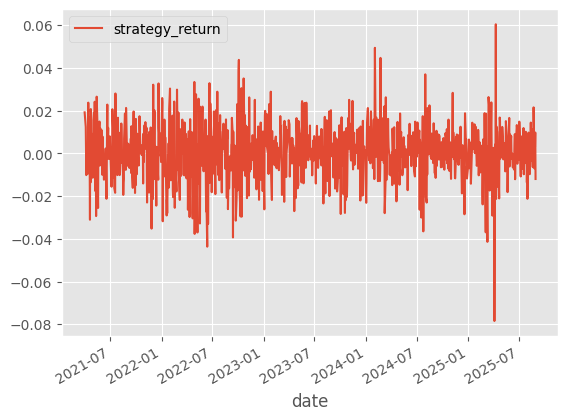

In [175]:
portfolio_df.plot()

In [176]:
spy = yf.download(tickers='SPY',
                  auto_adjust=False,
                    start='2022-02-01',
                    end='2025-10-31')

spy_ret = np.log(spy['Adj Close']).diff().dropna().rename({'SPY': 'SPY Buy and Hold'}, axis=1)


portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

[*********************100%***********************]  1 of 1 completed


In [177]:
portfolio_df

,strategy_return,SPY Buy and Hold
2022-02-02,0.002501,0.009667
2022-02-03,-0.012553,-0.023786
2022-02-04,-0.009892,0.004691
2022-02-07,0.006780,-0.003215
2022-02-08,0.010093,0.008194
...,...,...
2025-08-25,-0.006986,-0.004411
2025-08-26,0.007033,0.004178
2025-08-27,0.003086,0.002276
2025-08-28,0.009823,0.003535


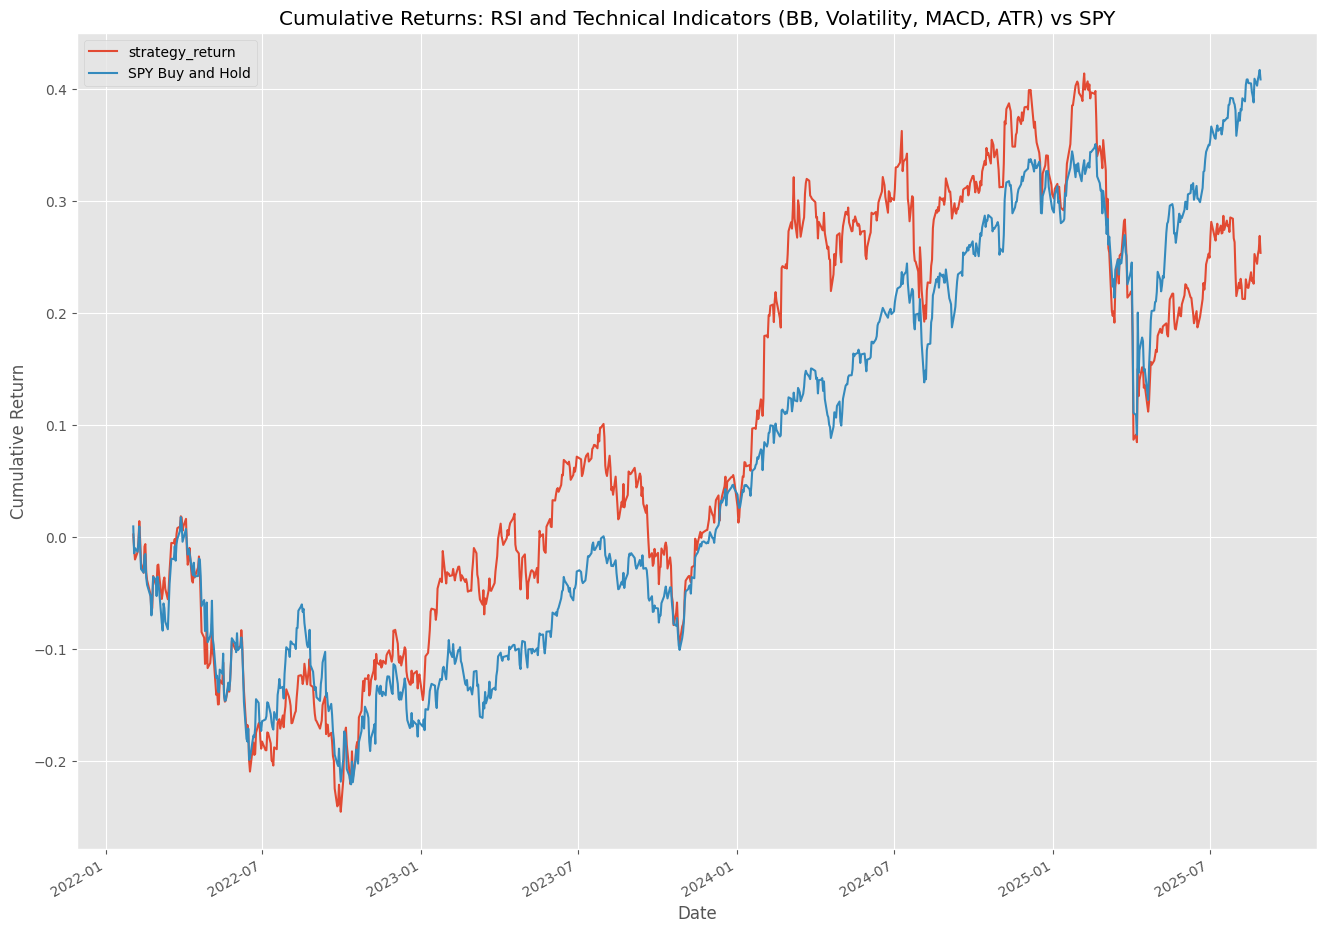

In [178]:
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 12))
portfolio_cumulative_return.plot(ax=ax)
plt.title("Cumulative Returns: RSI and Technical Indicators (BB, Volatility, MACD, ATR) vs SPY")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()